Saved plot to: /home/zsarwar/Projects/neox/gpt-neox-base-moe/code/plots/4c1_4c1 + l-16-r-8.pdf


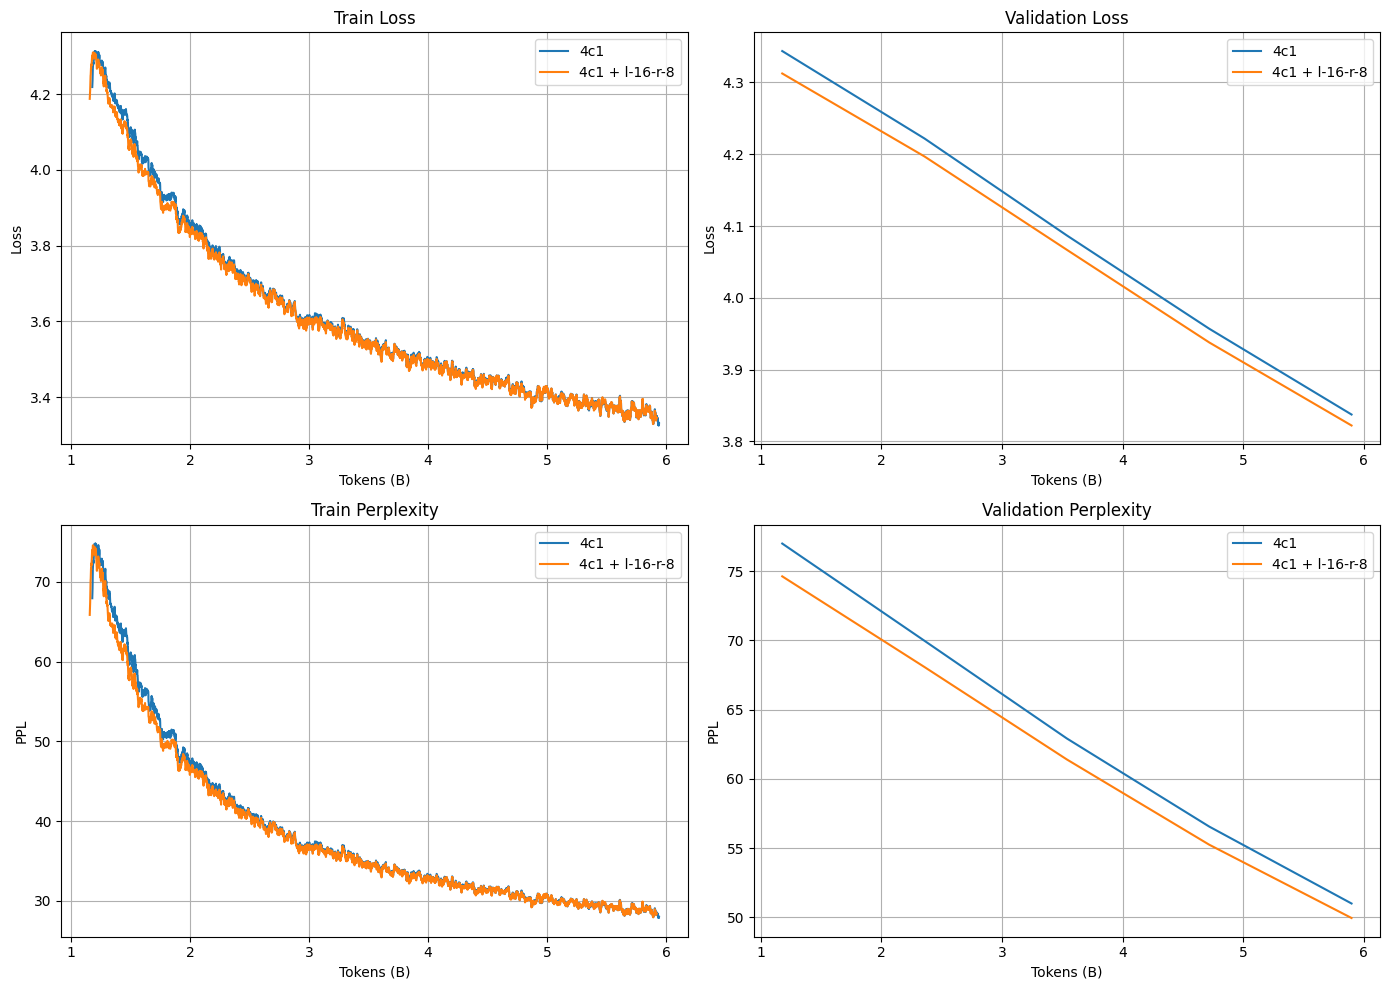

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator



# ckpt_paths = [
#     "/net/scratch/zsarwar/exps/GPT_experts-1-topk-1-layers12-heads-12/b001-9aae413635a59a1bd748912a1d6a8077/tensorboard",
#     # "/net/scratch/zsarwar/exps/GPT_experts-1-topk-1-layers12-heads-12/j002-f8d4350954da3c455cfb58e12936d732/tensorboard",
#     "/net/scratch/zsarwar/exps/GPT_experts-1-topk-1-layers12-heads-12/w002-300bc04cda9f137ea77a2da53d51d3f4/tensorboard",
#     # "/net/scratch/zsarwar/exps/GPT_experts-1-topk-1-layers12-heads-12/k001-e219b0857385c22aca203fa5ca4c6110_2/tensorboard"
# ]
# legend_keys = [
#     "1c1 + l-16-r-8",
#     # "1c1 + l-8_r-4",
#     "1c1",
#     # "1c1 + l-16-r-4",

# ]


# # === Config ===
# ckpt_paths = [
#     "/net/scratch/zsarwar/exps/GPT_experts-8-topk-1-layers12-heads-12/k001-38abff837ec0d231d3e9eb56c9cdb6ac/tensorboard/",
#     # "/net/scratch/zsarwar/exps/GPT_experts-8-topk-2-layers12-heads-12/k001-bf438c8582fa76d72c2527fa61802b74/tensorboard",
#     "/net/scratch/zsarwar/exps/GPT_experts-7-topk-1-layers12-heads-12/e002-af3b953a6664974775edb480246a64fc/tensorboard",
#     # "/net/scratch/zsarwar/exps/GPT_experts-7-topk-1-layers12-heads-12/b003-82d0e08a0c26696f7991aaa0671ae599/tensorboard"
# ]
# legend_keys = [
#     "8c1",
#     # "8c2",
#     "7c1+Lora8c1",
#     # "7c1",

# ]


# # === Config ===
ckpt_paths = [
"/net/scratch/zsarwar/exps/GPT_experts-4-topk-1-layers12-heads-12/w001-446d5e9e78a690921a149c65320e1eea/tensorboard/",
"/net/scratch/zsarwar/exps/GPT_experts-4-topk-1-layers12-heads-12/w001-ec38fe523db7eb59419fcd573e308e8d/tensorboard/"
]
legend_keys = [
    "4c1",
    "4c1 + l-16-r-8"
]



key_x = '_'.join(legend_keys)
save_path = f"/home/zsarwar/Projects/neox/gpt-neox-base-moe/code/plots/{key_x}.pdf"  # Set to None to disable saving


def steps_to_tokens(steps):
    dp_size = 16
    batch_size = 36
    seq_len = 2048
    divv = 1e9
    mult = (batch_size * seq_len * dp_size) / divv
    tokens = [step * mult for step in steps]
    return tokens

ppl_start_threshold = 70
smoothing_train = 0.9
smoothing_val = 0.8

def smooth(vals, factor):
    if factor == 0:
        return vals
    smoothed = []
    last = vals[0]
    for v in vals:
        last = last * factor + (1 - factor) * v
        smoothed.append(last)
    return smoothed

# --- Storage ---
train_loss_all = []
val_loss_all = []
train_ppl_all = []
val_ppl_all = []
train_steps_all = []
val_steps_all = []

# --- Load runs ---
for path in ckpt_paths:
    ea = event_accumulator.EventAccumulator(path)
    ea.Reload()

    train_loss_events = ea.Scalars("train/lm_loss")
    val_loss_events = ea.Scalars("validation/lm_loss")
    val_ppl_events = ea.Scalars("validation/lm_loss_ppl")

    steps = [e.step for e in train_loss_events]
    train_loss = [e.value for e in train_loss_events]
    train_ppl = [np.exp(v) for v in train_loss]

    start = next((i for i, v in enumerate(train_ppl) if v < ppl_start_threshold), 0)

    steps = steps_to_tokens(steps[start:])

    train_loss = smooth(train_loss[start:], smoothing_train)
    train_ppl = smooth(train_ppl[start:], smoothing_train)

    val_steps = steps_to_tokens([e.step for e in val_loss_events])
    val_loss = smooth([e.value for e in val_loss_events], smoothing_val)
    val_ppl = smooth([e.value for e in val_ppl_events], smoothing_val)



    train_steps_all.append(steps)
    val_steps_all.append(val_steps)
    train_loss_all.append(train_loss)
    val_loss_all.append(val_loss)
    train_ppl_all.append(train_ppl)
    val_ppl_all.append(val_ppl)



# --- Clip to shortest run for training plots ---
min_train_len = min(len(steps) for steps in train_steps_all)

for i in range(len(train_steps_all)):
    train_steps_all[i] = train_steps_all[i][:min_train_len]
    train_loss_all[i] = train_loss_all[i][:min_train_len]
    train_ppl_all[i] = train_ppl_all[i][:min_train_len]


# --- Clip to shortest run for valing plots ---
min_val_len = min(len(steps) for steps in val_steps_all)

for i in range(len(val_steps_all)):
    val_steps_all[i] = val_steps_all[i][:min_val_len]
    val_loss_all[i] = val_loss_all[i][:min_val_len]
    val_ppl_all[i] = val_ppl_all[i][:min_val_len]







# --- Plotting ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
(ax1, ax2), (ax3, ax4) = axes

# Train Loss
for i in range(len(ckpt_paths)):
    ax1.plot(train_steps_all[i], train_loss_all[i], label=legend_keys[i])
ax1.set_title("Train Loss")
ax1.set_xlabel("Tokens (B)")
ax1.set_ylabel("Loss")
ax1.grid(True)
ax1.legend()

# Validation Loss
for i in range(len(ckpt_paths)):
    ax2.plot(val_steps_all[i], val_loss_all[i], label=legend_keys[i])
ax2.set_title("Validation Loss")
ax2.set_xlabel("Tokens (B)")
ax2.set_ylabel("Loss")
ax2.grid(True)
ax2.legend()

# Train PPL
for i in range(len(ckpt_paths)):
    ax3.plot(train_steps_all[i], train_ppl_all[i], label=legend_keys[i])
ax3.set_title("Train Perplexity")
ax3.set_xlabel("Tokens (B)")
ax3.set_ylabel("PPL")
ax3.grid(True)
ax3.legend()

# Validation PPL
for i in range(len(ckpt_paths)):
    ax4.plot(val_steps_all[i], val_ppl_all[i], label=legend_keys[i])
ax4.set_title("Validation Perplexity")
ax4.set_xlabel("Tokens (B)")
ax4.set_ylabel("PPL")
ax4.grid(True)
ax4.legend()

plt.tight_layout()



# --- Save as PDF if specified ---
if save_path:
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Saved plot to: {save_path}")


plt.show()

Saved plot to: /home/zsarwar/Projects/neox/gpt-neox-base-moe/code/plots_1c1 + l-16-r-8_1c1 + l-8_r-4_1c1_1c1 + l-16-r-4.pdf


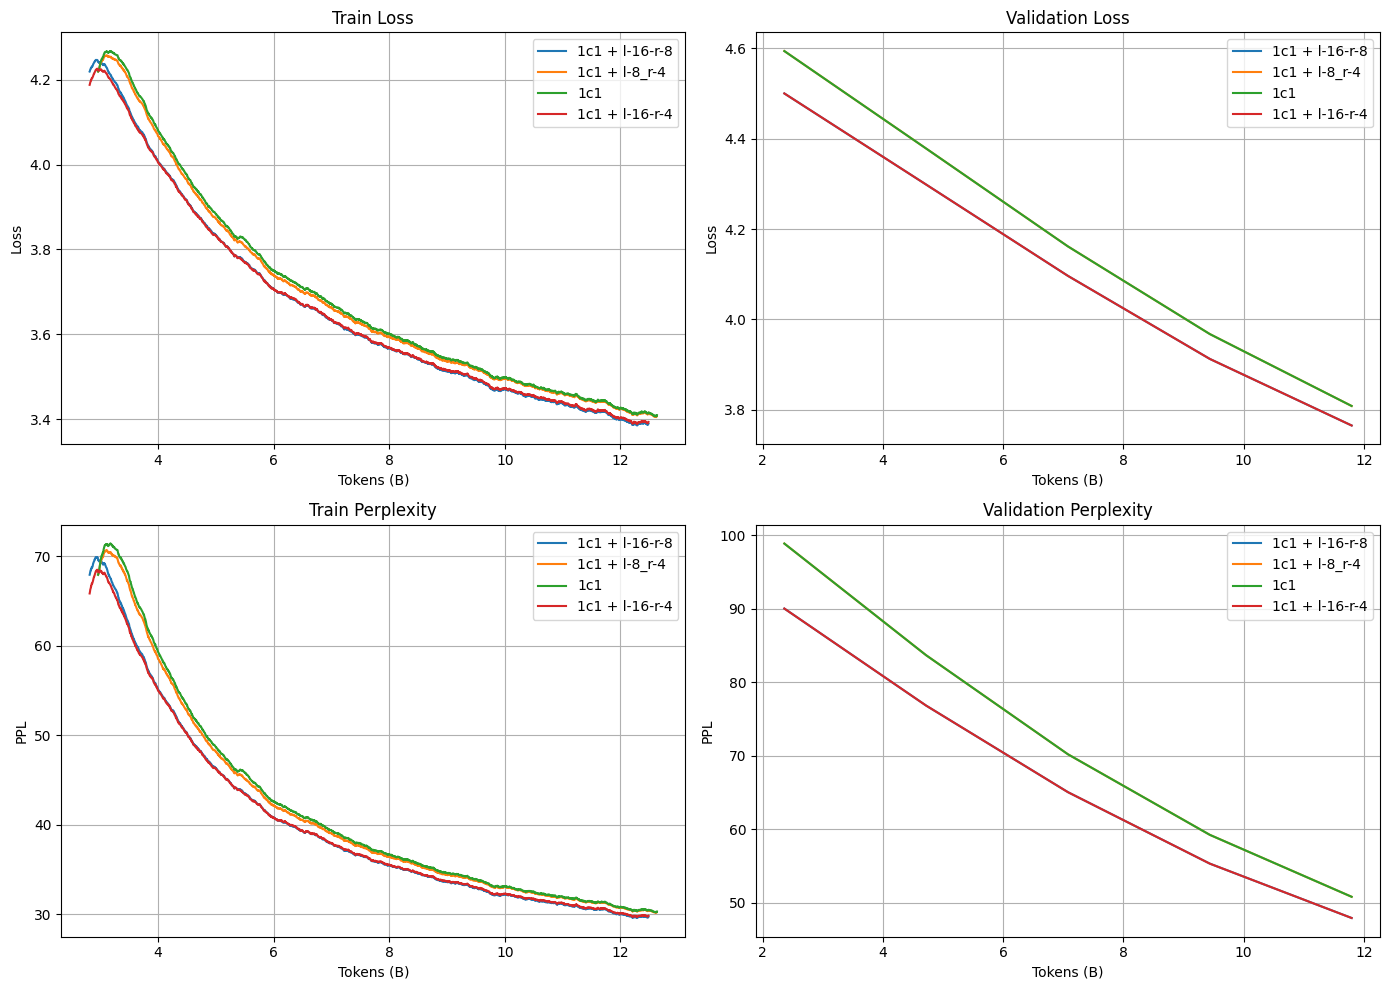

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator

# # === Config ===
# ckpt_paths = [
#     "/net/scratch/zsarwar/exps/GPT_experts-8-topk-1-layers12-heads-12/k001-38abff837ec0d231d3e9eb56c9cdb6ac/tensorboard/",
#     "/net/scratch/zsarwar/exps/GPT_experts-8-topk-2-layers12-heads-12/k001-bf438c8582fa76d72c2527fa61802b74/tensorboard",
#     "/net/scratch/zsarwar/exps/GPT_experts-7-topk-1-layers12-heads-12/e002-af3b953a6664974775edb480246a64fc/tensorboard",
#     "/net/scratch/zsarwar/exps/GPT_experts-7-topk-1-layers12-heads-12/b003-82d0e08a0c26696f7991aaa0671ae599/tensorboard"
# ]
# legend_keys = [
#     "8c1",
#     "8c2",
#     "7c1+Lora8c1",
#     "7c1",

# ]


ckpt_paths = [
    "/net/scratch/zsarwar/exps/GPT_experts-1-topk-1-layers12-heads-12/b001-9aae413635a59a1bd748912a1d6a8077/tensorboard",
    "/net/scratch/zsarwar/exps/GPT_experts-1-topk-1-layers12-heads-12/j002-f8d4350954da3c455cfb58e12936d732/tensorboard",
    "/net/scratch/zsarwar/exps/GPT_experts-1-topk-1-layers12-heads-12/k001-adaf0f8e79726ae36a91870108224296_x/tensorboard",
    "/net/scratch/zsarwar/exps/GPT_experts-1-topk-1-layers12-heads-12/k001-e219b0857385c22aca203fa5ca4c6110_2/tensorboard"
]
legend_keys = [
    "1c1 + l-16-r-8",
    "1c1 + l-8_r-4",
    "1c1",
    "1c1 + l-16-r-4",

]
key_x = '_'.join(legend_keys)
save_path = f"/home/zsarwar/Projects/neox/gpt-neox-base-moe/code/plots/{key_x}.pdf"  # Set to None to disable saving


def steps_to_tokens(steps):
    dp_size = 32
    batch_size = 36
    seq_len = 2048
    divv = 1e9
    mult = (batch_size * seq_len * dp_size) / divv
    tokens = [step * mult for step in steps]
    return tokens

ppl_start_threshold = 70
smoothing_train = 0.99
smoothing_val = 0.7

def smooth(vals, factor):
    if factor == 0:
        return vals
    smoothed = []
    last = vals[0]
    for v in vals:
        last = last * factor + (1 - factor) * v
        smoothed.append(last)
    return smoothed

# --- Storage ---
train_loss_all = []
val_loss_all = []
train_ppl_all = []
val_ppl_all = []
train_steps_all = []
val_steps_all = []

# --- Load runs ---
for path in ckpt_paths:
    ea = event_accumulator.EventAccumulator(path)
    ea.Reload()

    train_loss_events = ea.Scalars("train/lm_loss")
    val_loss_events = ea.Scalars("validation/lm_loss")
    val_ppl_events = ea.Scalars("validation/lm_loss_ppl")

    steps = [e.step for e in train_loss_events]
    train_loss = [e.value for e in train_loss_events]
    train_ppl = [np.exp(v) for v in train_loss]

    start = next((i for i, v in enumerate(train_ppl) if v < ppl_start_threshold), 0)

    steps = steps_to_tokens(steps[start:])

    train_loss = smooth(train_loss[start:], smoothing_train)
    train_ppl = smooth(train_ppl[start:], smoothing_train)

    val_steps = steps_to_tokens([e.step for e in val_loss_events])
    val_loss = smooth([e.value for e in val_loss_events], smoothing_val)
    val_ppl = smooth([e.value for e in val_ppl_events], smoothing_val)



    train_steps_all.append(steps)
    val_steps_all.append(val_steps)
    train_loss_all.append(train_loss)
    val_loss_all.append(val_loss)
    train_ppl_all.append(train_ppl)
    val_ppl_all.append(val_ppl)



# --- Clip to shortest run for training plots ---
min_train_len = min(len(steps) for steps in train_steps_all)

for i in range(len(train_steps_all)):
    train_steps_all[i] = train_steps_all[i][:min_train_len]
    train_loss_all[i] = train_loss_all[i][:min_train_len]
    train_ppl_all[i] = train_ppl_all[i][:min_train_len]


# --- Clip to shortest run for valing plots ---
min_val_len = min(len(steps) for steps in val_steps_all)

for i in range(len(val_steps_all)):
    val_steps_all[i] = val_steps_all[i][:min_val_len]
    val_loss_all[i] = val_loss_all[i][:min_val_len]
    val_ppl_all[i] = val_ppl_all[i][:min_val_len]







# --- Plotting ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
(ax1, ax2), (ax3, ax4) = axes

# Train Loss
for i in range(len(ckpt_paths)):
    ax1.plot(train_steps_all[i], train_loss_all[i], label=legend_keys[i])
ax1.set_title("Train Loss")
ax1.set_xlabel("Tokens (B)")
ax1.set_ylabel("Loss")
ax1.grid(True)
ax1.legend()

# Validation Loss
for i in range(len(ckpt_paths)):
    ax2.plot(val_steps_all[i], val_loss_all[i], label=legend_keys[i])
ax2.set_title("Validation Loss")
ax2.set_xlabel("Tokens (B)")
ax2.set_ylabel("Loss")
ax2.grid(True)
ax2.legend()

# Train PPL
for i in range(len(ckpt_paths)):
    ax3.plot(train_steps_all[i], train_ppl_all[i], label=legend_keys[i])
ax3.set_title("Train Perplexity")
ax3.set_xlabel("Tokens (B)")
ax3.set_ylabel("PPL")
ax3.grid(True)
ax3.legend()

# Validation PPL
for i in range(len(ckpt_paths)):
    ax4.plot(val_steps_all[i], val_ppl_all[i], label=legend_keys[i])
ax4.set_title("Validation Perplexity")
ax4.set_xlabel("Tokens (B)")
ax4.set_ylabel("PPL")
ax4.grid(True)
ax4.legend()

plt.tight_layout()



# --- Save as PDF if specified ---
if save_path:
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Saved plot to: {save_path}")


plt.show()

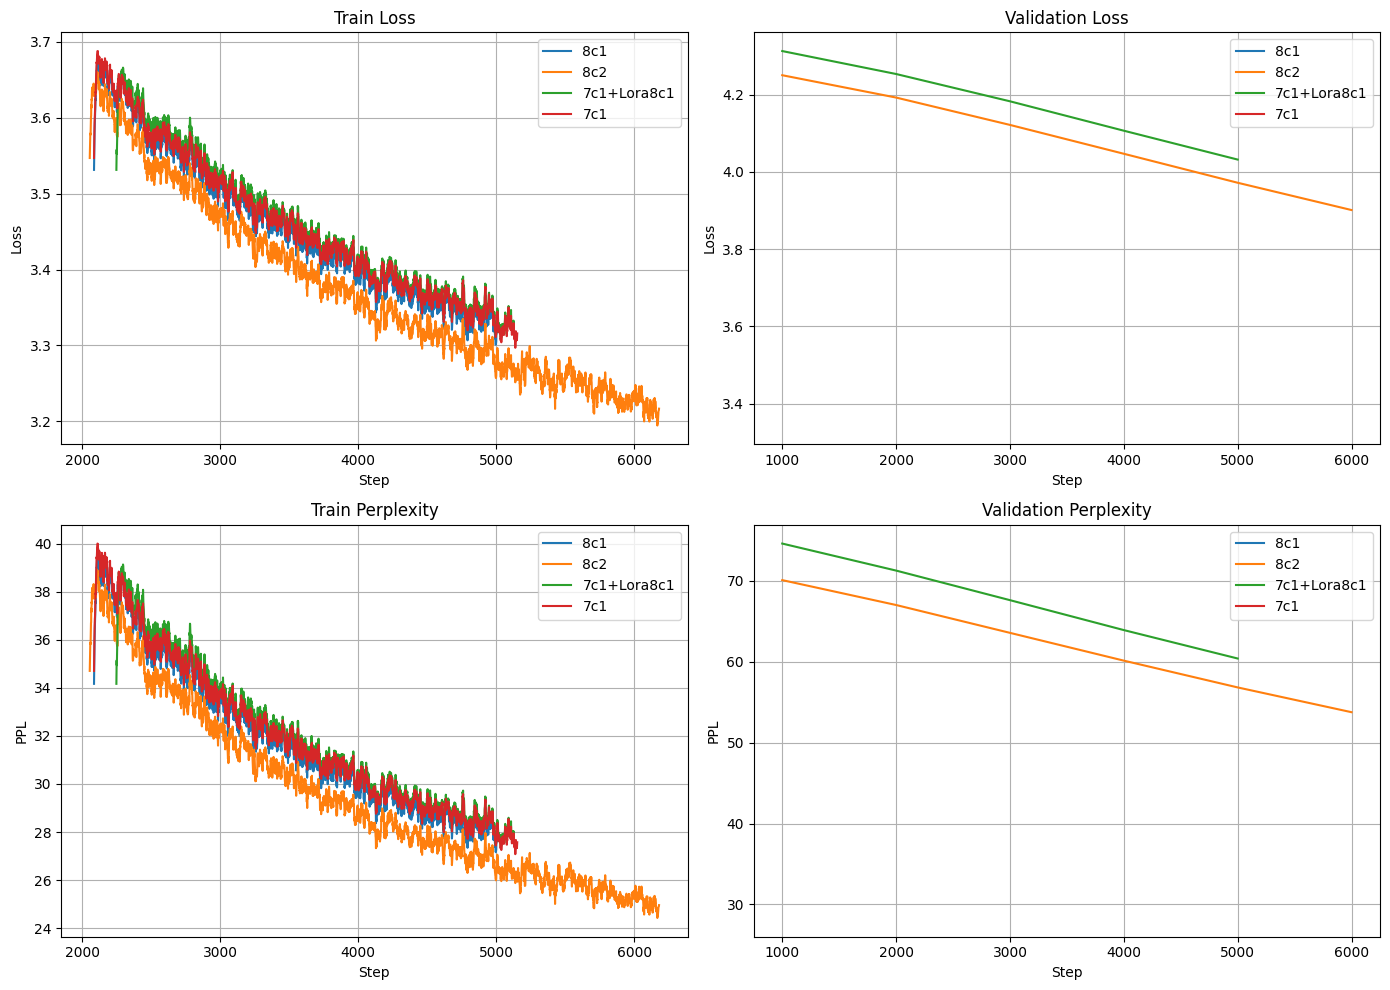

In [21]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator

# === Config ===
ckpt_paths = [
    "/net/scratch/zsarwar/exps/GPT_experts-8-topk-1-layers12-heads-12/k001-38abff837ec0d231d3e9eb56c9cdb6ac/tensorboard/",
    "/net/scratch/zsarwar/exps/GPT_experts-8-topk-2-layers12-heads-12/k001-bf438c8582fa76d72c2527fa61802b74/tensorboard",
    "/net/scratch/zsarwar/exps/GPT_experts-7-topk-1-layers12-heads-12/e002-af3b953a6664974775edb480246a64fc/tensorboard",
    "/net/scratch/zsarwar/exps/GPT_experts-7-topk-1-layers12-heads-12/b003-82d0e08a0c26696f7991aaa0671ae599/tensorboard"
]
legend_keys = [
    "8c1",
    "8c2",
    "7c1+Lora8c1",
    "7c1",

]


ppl_start_threshold = 35
smoothing = 0.9
key_x = '_'.join(legend_keys)
save_path = f"/home/zsarwar/Projects/neox/gpt-neox-base-moe/code/plots_{key_x}.pdf"  # Set to None to disable saving
save_path = None
def smooth(vals, factor):
    if factor == 0:
        return vals
    smoothed = []
    last = vals[0]
    for v in vals:
        last = last * factor + (1 - factor) * v
        smoothed.append(last)
    return smoothed

train_loss_all = []
val_loss_all = []
train_ppl_all = []
val_ppl_all = []
train_steps_all = []
val_steps_all = []

for path in ckpt_paths:
    ea = event_accumulator.EventAccumulator(path)
    ea.Reload()

    train_loss_events = ea.Scalars("train/lm_loss")
    val_loss_events = ea.Scalars("validation/lm_loss")
    val_ppl_events = ea.Scalars("validation/lm_loss_ppl")

    steps = [e.step for e in train_loss_events]
    train_loss = [e.value for e in train_loss_events]
    train_ppl = [np.exp(v) for v in train_loss]

    start = next((i for i, v in enumerate(train_ppl) if v < ppl_start_threshold), 0)

    steps = steps[start:]
    train_loss = smooth(train_loss[start:], smoothing)
    train_ppl = smooth(train_ppl[start:], smoothing)

    val_steps = [e.step for e in val_loss_events]
    val_loss = smooth([e.value for e in val_loss_events], smoothing)
    val_ppl = smooth([e.value for e in val_ppl_events], smoothing)

    train_steps_all.append(steps)
    val_steps_all.append(val_steps)
    train_loss_all.append(train_loss)
    val_loss_all.append(val_loss)
    train_ppl_all.append(train_ppl)
    val_ppl_all.append(val_ppl)

# --- Plotting ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
(ax1, ax2), (ax3, ax4) = axes

# Train Loss
for i in range(len(ckpt_paths)):
    ax1.plot(train_steps_all[i], train_loss_all[i], label=legend_keys[i])
ax1.set_title("Train Loss")
ax1.set_xlabel("Step")
ax1.set_ylabel("Loss")
ax1.grid(True)
ax1.legend()

# Validation Loss
for i in range(len(ckpt_paths)):
    ax2.plot(val_steps_all[i], val_loss_all[i], label=legend_keys[i])
ax2.set_title("Validation Loss")
ax2.set_xlabel("Step")
ax2.set_ylabel("Loss")
ax2.grid(True)
ax2.legend()

# Train PPL
for i in range(len(ckpt_paths)):
    ax3.plot(train_steps_all[i], train_ppl_all[i], label=legend_keys[i])
ax3.set_title("Train Perplexity")
ax3.set_xlabel("Step")
ax3.set_ylabel("PPL")
ax3.grid(True)
ax3.legend()

# Validation PPL
for i in range(len(ckpt_paths)):
    ax4.plot(val_steps_all[i], val_ppl_all[i], label=legend_keys[i])
ax4.set_title("Validation Perplexity")
ax4.set_xlabel("Step")
ax4.set_ylabel("PPL")
ax4.grid(True)
ax4.legend()

plt.tight_layout()

# --- Save as PDF if specified ---
if save_path:
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Saved plot to: {save_path}")

plt.show()